Following this guide for understanding and building: https://www.youtube.com/watch?v=TCH_1BHY58I

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [42]:
# Loading in data 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [43]:
chars = sorted(list(set(''.join(words)))) # Get all possible letters 
# Apply index based mapping
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char, i in stoi.items()}
vocab_size = len(itos)

In [71]:
# Build dataset 
block_size = 3

def build_dataset(words): 
    x=[]
    y=[]

    for word in words:
        context = [0] * block_size

        for char in word + '.': #need to add ending indicator
            index = stoi[char]
            #print(context)
            x.append(context)
            y.append(index)
            #print(''.join(itos[i] for i in context), '----->', itos[y[-1]])
            context = context[1:] + [index]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest,ytest = build_dataset(words[n2:])

In [72]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g)
b1 = torch.randn((n_hidden),                        generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g)
b2 = torch.randn((vocab_size),                      generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [73]:
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.7189
  10000/ 200000: 2.6191
  20000/ 200000: 2.9194
  30000/ 200000: 2.6206
  40000/ 200000: 2.1360
  50000/ 200000: 2.3207
  60000/ 200000: 2.2866
  70000/ 200000: 2.4830
  80000/ 200000: 2.5367
  90000/ 200000: 2.4002
 100000/ 200000: 2.0727
 110000/ 200000: 2.2361
 120000/ 200000: 2.0168
 130000/ 200000: 2.6164
 140000/ 200000: 2.3628
 150000/ 200000: 2.1042
 160000/ 200000: 1.9215
 170000/ 200000: 1.9828
 180000/ 200000: 2.6498
 190000/ 200000: 2.0295


#### Fixing High Loss thorugh Proper Initialization 

See the obvious problem here? The first few thousand of iterations are wasted on trying to get the network to a lower reasonable state, since the network is confidently wrong. On a small network like this one, it isn't a problem, but if instead the network were in a state of near zero initialization, the network would be in a much more ready state to learn. 

Assuming equal probability the expected loss should be -torch.tensor(1/27).log() = 3.2958 which is significantly lower than 26.7189 

So how do we go about reducing the inital loss? Adjust the randomly initalized parameters!

Below, training is stopped after a single iteration to show the new loss of the adjusted parameters with loss being 3.3055.

Bias is a parameter that is learned can be set to a matrix of zeros and by adjust the W2 matrix to near zero, the initial training loss is reduced further. It is important to have it near zero so the system has some entropy to introducing symmetry breaking. 

In [91]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g)
b1 = torch.randn((n_hidden),                        generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break 

11897
      0/ 200000: 3.2846


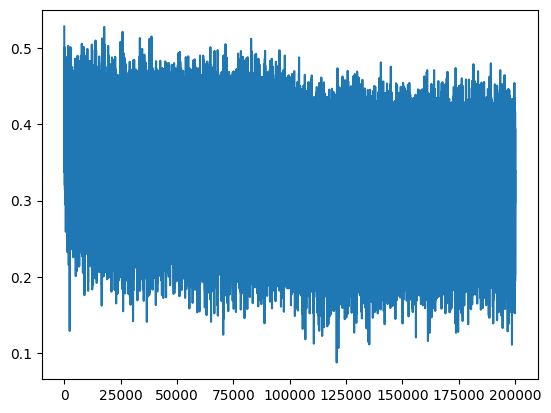

In [79]:
plt.plot(lossi) # No more hockey stick since the initialization isnt trash anymore

#### Fixing the activation function distribution:

The loss is "fixed" at initialization, but deeper problems lie within the intialization of the network. Becasue of the bounds of the activation function where tanh(x>2) ≈ 1 and tanh(x<-2) ≈ -1, during backprop of the tanh function, the gradient effectively gets zero'd out meaning there will be no updates to this node. During input, there are 32 (batchsize) potential inputs that all produce some unique acivation function gradients ranging from -1 to 1 for each of the 200 different neurons. If all the activation functions for a node reach either 1,-1, then the node is dead and cannot learn regardless of the input. 

##### Make sure to inspect activation values at instantiation so ya bois can learn!!!

How to fix: Balance inital weight and bias matrix as well to ensure that confidently wrong values aren't present 

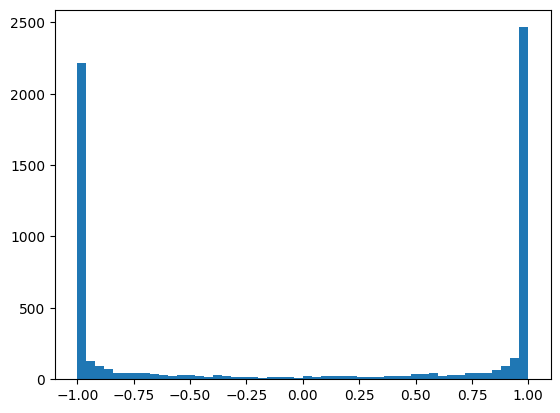

In [82]:
plt.hist(h.view(-1).tolist(), 50);
# Like I said, this is extremely bad to see since the leanring happens in the middle

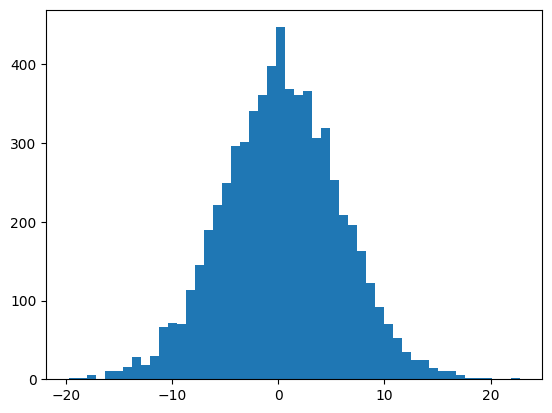

In [92]:
plt.hist(hpreact.view(-1).tolist(), 50);
# Way too many extreme values sitting past 2,-2

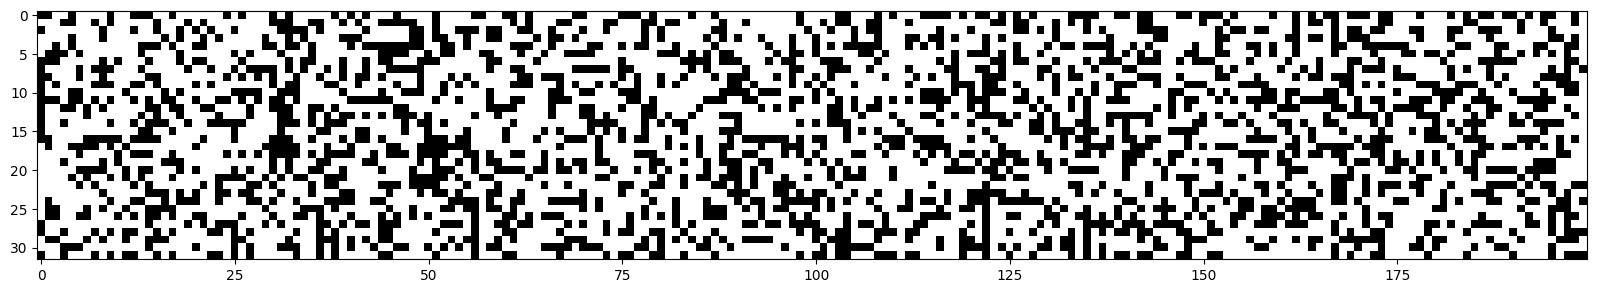

In [86]:
# Taking a closer look to see if there are infact any dead neurons, but keep in mind that the white ones are either not learning or are learning VERY slowly
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

After training results:

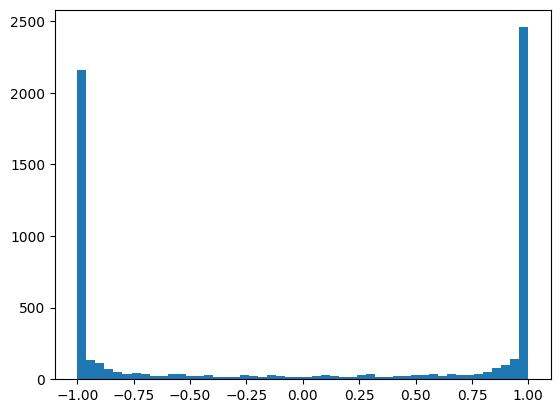

In [93]:
plt.hist(h.view(-1).tolist(), 50);

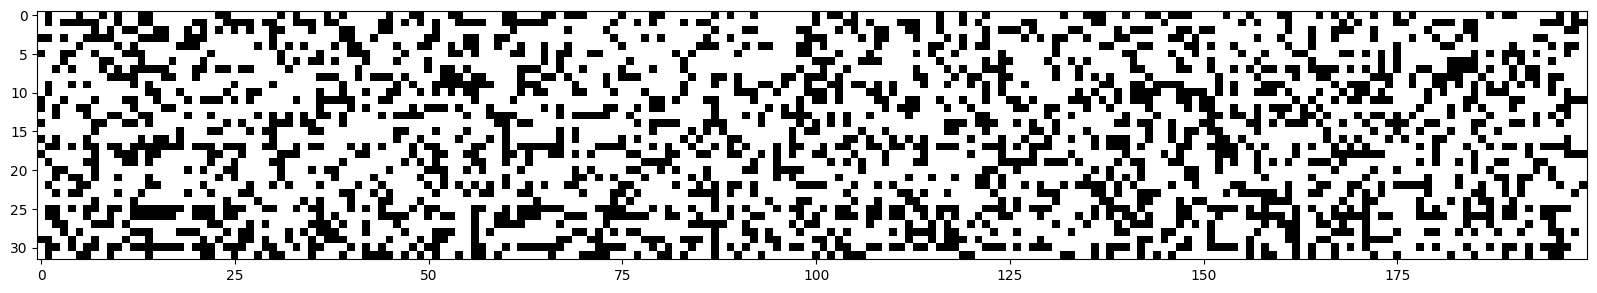

In [89]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [99]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * 0.2 # 
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break 

11897
      0/ 200000: 3.3042


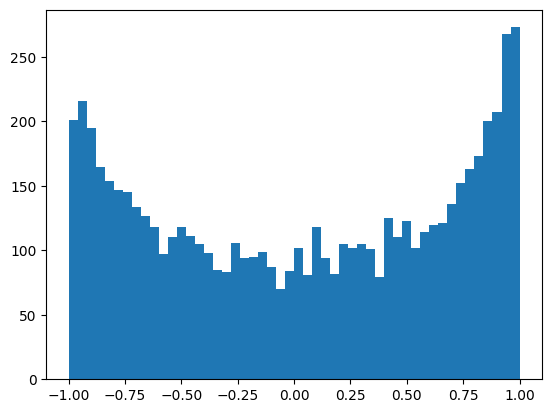

In [100]:
plt.hist(h.view(-1).tolist(), 50);
# activation function looks much cleaner and ready to learn 

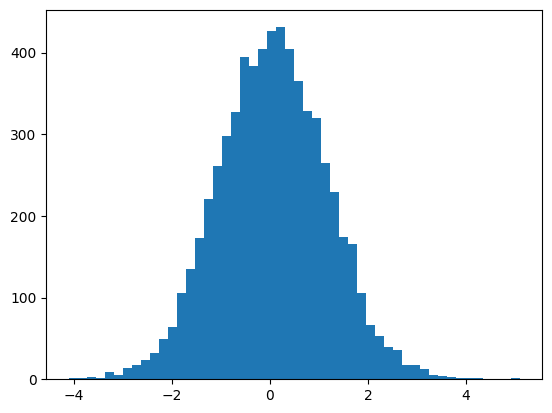

In [101]:
plt.hist(hpreact.view(-1).tolist(), 50);
# An obvious direct result of setting the weights to reasonable bounds 

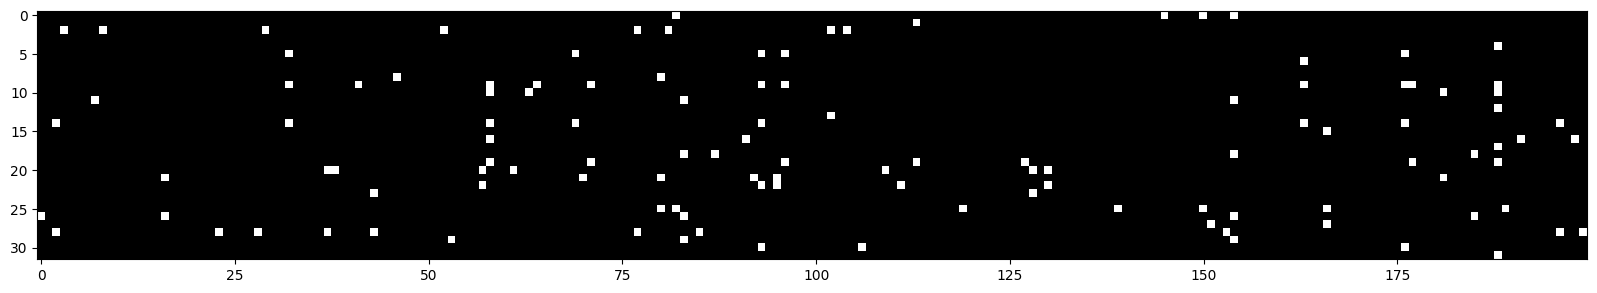

In [103]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') #you want some white 

#### Dealing with matrix multiplication resulting in larger varience and values:

When the NN is progressing through the layers, the inevitable multiplication of the the previously activated layer (hpreact) and the current weights (W2) will lead to the mean staying the same, but the varience increases. And so do the values, leading to the problem that was being faced before, where these values are not well bounded and can lead to increasingly large values that make it impossible for the NN to learn through back propigation. Exemplified below is the multiplcation of two normal distributions leading to a gain fo 3x for the varience.

The fix: 
- Kaiming initialization (divide matrix by $\sqrt{fanin}$) where fan_in == the number of inner layers being multiplied by (in the example below, this would be 10) and for tanh there is also a gain of 5/3 that needs to be multiplied in as well
    - Some intuition around gain is that since tanh is squashing everything to be between -1,1, there needs to be some pushback to get the varience to behave to return to 1 
    - As well, when you apply this scaling function to keep mean at 0 and varience at 1, the backprop is also well behaved 
- Residual connections (used in GRUs and LSTMs) will be covered later 
- Layer normalization techniques:
    - Batch Norm
    - Layer normalization
    - Group normalization
- Better optimizers (than SGD)
    - RMSProp
    - ADAM (RMSProp + momentum)

tensor(0.0105) tensor(1.0164)
tensor(-0.0071) tensor(0.3180)
tensor(-0.0027) tensor(1.0178)


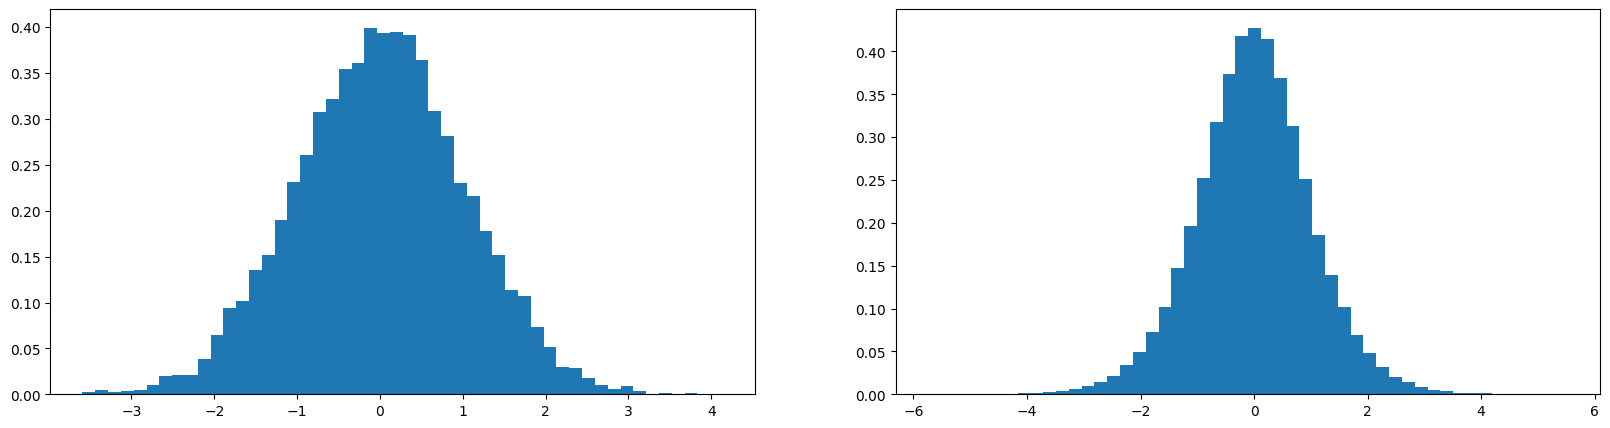

In [109]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);
# So despite the two normal distributions being well behaved, the varience still finds a way to increase 3x which leads to the high amount of values finding themselevs at the tails. 

In [111]:
# Using the kaiming init method 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * (5/3)/((n_embed * block_size)**0.5) #kaiming init method
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.2902
  10000/ 200000: 2.1222
  20000/ 200000: 2.1223
  30000/ 200000: 2.2104
  40000/ 200000: 2.1326
  50000/ 200000: 2.1810
  60000/ 200000: 2.0915
  70000/ 200000: 2.0586
  80000/ 200000: 2.6180
  90000/ 200000: 1.7655
 100000/ 200000: 1.9969
 110000/ 200000: 2.0288
 120000/ 200000: 1.8357
 130000/ 200000: 1.9944
 140000/ 200000: 2.0031
 150000/ 200000: 1.9664
 160000/ 200000: 2.2396
 170000/ 200000: 1.7651
 180000/ 200000: 2.4940
 190000/ 200000: 1.8545


In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036756992340088
val 2.1078274250030518
